In [1]:
import neural_net_without_autograd as NNC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.model_selection import  train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
np.random.seed(2)

# --- defining the Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# --- Generating dataset
n = 100 # the square root of the number of datapoints
x, y = np.linspace(0,1,n), np.linspace(0,1,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

k = .01 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise
z = z.reshape((len(z), 1))      # have to reshape the data to get the correct output

X = np.column_stack((x,y))

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

In [10]:
# Define layer sizes and activations
network_input_size =  2
layer_output_sizes = [50, 1]
activations = ['sigmoid', 'identity']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', NNC.NeuralNet(network_input_size, 
                            layer_output_sizes, 
                            activations, 
                            loss_fn='mse', 
                            epsilon=0.01, 
                            batch_size=100, 
                            epochs=1000, 
                            llambda=0.001))
])

# getting data for confusion matrix
pipeline.fit(X_train, z_train)

pipeline.score(X_test, z_test)

Epoch 0: MSE = 0.14245764345495557
Epoch 100: MSE = 0.011469785835621828
Epoch 200: MSE = 0.008049491801038321
Epoch 300: MSE = 0.0063711543954903934
Epoch 400: MSE = 0.005520171051490775
Epoch 500: MSE = 0.00516351432721123
Epoch 600: MSE = 0.005079813263674044
Epoch 700: MSE = 0.005135292744583709
Epoch 800: MSE = 0.005258868858543904
Epoch 900: MSE = 0.005413331624565207


0.005046935300256898

### Gridsearch

In [4]:
k_folds = KFold(n_splits=10)

pipeline = Pipeline([
    ('model', NNC.NeuralNet(network_input_size, layer_output_sizes, activations, loss_fn='mse', batch_size=100, epochs=500))
])
param_grid = {
    'model__epsilon': np.logspace(-4, -1, 4),
    'model__llambda': np.logspace(-4, -1, 4)
}

grid_search = GridSearchCV(estimator=pipeline,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=k_folds,
                verbose=1,
                n_jobs=1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Epoch 0: MSE = 0.3586461075730569
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(

KeyboardInterrupt: 

### Plotting the prediction and the data

In [11]:
z_total = pipeline.predict(X)

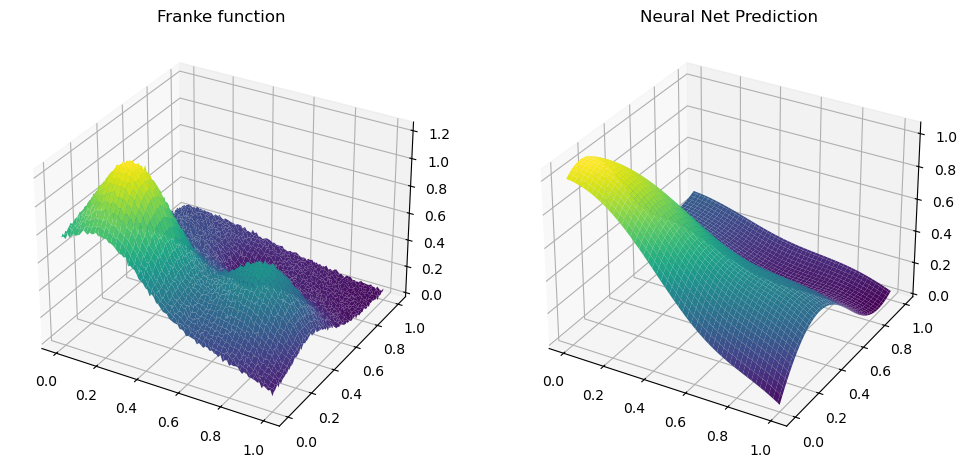

In [12]:
# Reshaping for plotting
x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))
z_orig_plot = z.reshape((n,n))

fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Franke function')
#ax.view_init(azim=230)

# Plot the polynomial regression prediction 
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('Neural Net Prediction')
#ax.view_init(azim=230)

plt.show()